In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf

# Data loading

In [3]:
import psycopg2
import pandas as pd

# Function to load data into a DataFrame
def load_data_to_dataframe():
    try:
        # Establish a connection to the PostgreSQL database
        connection = psycopg2.connect(
            host='10.10.10.10',  # Replace with your host
            port=5432,           # Default PostgreSQL port
            user='postgres',     # Replace with your username
            password='adm',      # Replace with your password
            database='adm'       # Replace with your database name
        )
        
        # Create a SQL query to retrieve 10,000 records
        # query = "SELECT body FROM reddit_2007 WHERE body != '[deleted]' and length(body) > 100 limit 30000;"
        query = "SELECT * FROM filtered LIMIT 200000;"

        # Load the data into a pandas DataFrame
        df = pd.read_sql_query(query, connection)

    except Exception as e:
        print("An error occurred:", e)

    finally:
        # Close the connection
        if connection:
            connection.close()
    
    return df

# Call the function to load data into a DataFrame
df = load_data_to_dataframe()

C:\Users\Marcin\AppData\Local\Temp\ipykernel_7292\2515642067.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [4]:
df = df[['body', 'subreddit']]

In [5]:
df.head()

,body,subreddit
0,I would bet it is a misquote or misrepresentat...,technology
1,"If it organized itself, it wouldn't require fo...",politics
2,A big wage hike would be great. I really bottl...,politics
3,Sensationalism in the news really works. Give...,technology
4,&gt; I did. I cited several performance compar...,programming


In [6]:
df.subreddit.value_counts()

subreddit
politics       96254
technology     29178
programming    26193
gaming         26134
science        22241
Name: count, dtype: int64

In [7]:
df = pd.concat([df[df['subreddit'] == subreddit].sample(8000, random_state=42)
               for subreddit in df['subreddit'].unique()]).reset_index(drop=True)
df['subreddit'].value_counts()

subreddit
technology     8000
politics       8000
programming    8000
gaming         8000
science        8000
Name: count, dtype: int64

# Data cleaning

In [8]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# Ensure consistent language detection
DetectorFactory.seed = 0

# Function to check if a text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False  # If detection fails, consider it non-English
    
print('Before filtering for English laguage: ', df.shape)

# Filter DataFrame to keep only English texts
df = df[df['body'].apply(is_english)]

print('After filtering for English laguage: ', df.shape)

Before filtering for English laguage:  (40000, 2)
After filtering for English laguage:  (39918, 2)


In [9]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk

nltk.download('stopwords')

# Initialize stemmer and stopwords
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the text data
df['clean_text'] = df['body'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marcin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
df['subreddit'].value_counts()

subreddit
science        7998
politics       7994
technology     7991
programming    7984
gaming         7951
Name: count, dtype: int64

# Bag of Words

In [11]:
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer()

# bow_matrix = vectorizer.fit_transform(df['clean_text'])

# X = bow_matrix.toarray()

# feature_names = vectorizer.get_feature_names_out()

# X.shape

# TF-IDF

In [12]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer(max_features=50)
# X = vectorizer.fit_transform(df['clean_text']).toarray()

# X.shape

# Word2Vev

# Dense Model

In [13]:
import gensim.downloader as api
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


print("Loading pre-trained Word2Vec model...")
word2vec = api.load("word2vec-google-news-300") 

text_data = df['clean_text'].values 

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['subreddit'])
labels = y 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(text_data)
padded_sequences = pad_sequences(sequences, padding='post')

vocab_size = len(word_index) + 1
embedding_dim = word2vec.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in word2vec.key_to_index:
        embedding_matrix[i] = word2vec[word]

Loading pre-trained Word2Vec model...


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [31]:
model = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              input_length=padded_sequences.shape[1], 
              trainable=False),
    tf.keras.layers.GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 neurons for 5 classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train, 
                    epochs=50, batch_size=128, validation_split=0.1, verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1463, 300)         24379800  
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 32)                9632      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                      

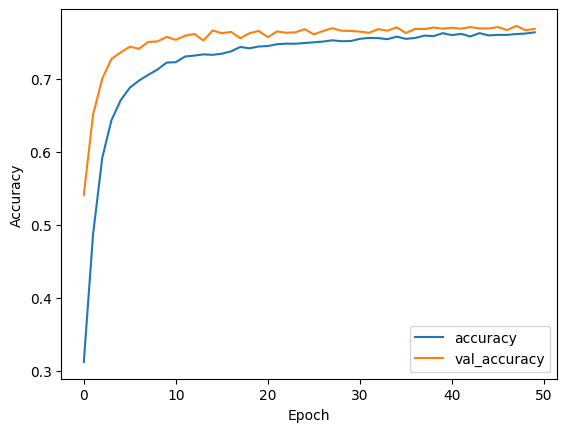

In [32]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('report/src/images/dense_accuracy.png')
plt.show()

In [33]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Loss: 0.6633, Accuracy: 0.7812


250/250 [==============================] - 0s 2ms/step


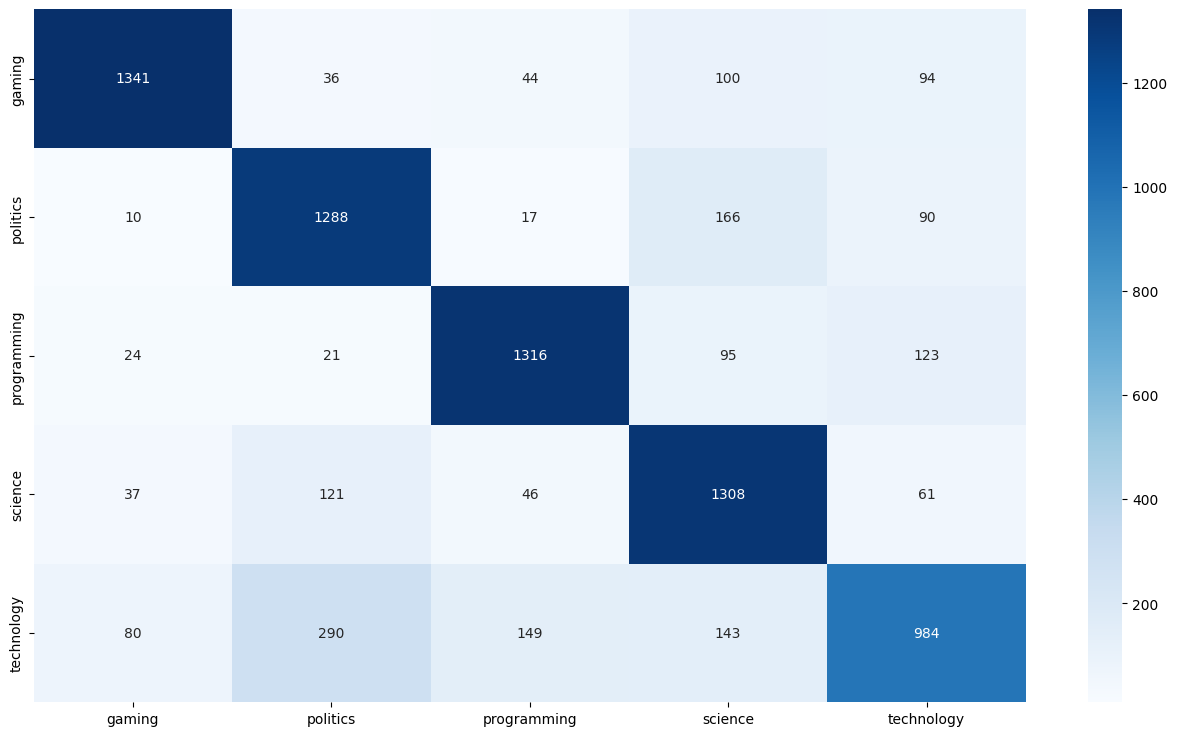

In [34]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(16, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.savefig('report/src/images/dense_confusion_matrix.png')
plt.show()

250/250 [==============================] - 1s 2ms/step


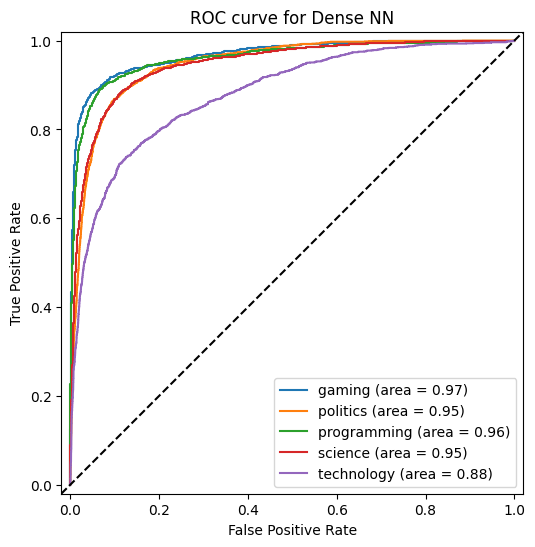

In [35]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

labels = label_encoder.classes_


y_score = model.predict(X_test)

# Plot ROC curve
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
limits = [-0.02, 1.02]
plt.figure(figsize=(6, 6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')
plt.plot(limits, limits,'k--')
plt.xlim(limits)
plt.ylim(limits)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(f'ROC curve for Dense NN')
plt.gca().set_aspect('equal')
plt.savefig(f'report/src/images/roc_dense.png', bbox_inches='tight')
plt.show()

# LSTM Model

In [36]:
model = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              input_length=padded_sequences.shape[1], 
              trainable=False),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.2),
    tf.keras.layers.Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.2),
    tf.keras.layers.Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.2),
    Dense(5, activation='softmax') 
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train, 
                    epochs=20, batch_size=64, validation_split=0.1, verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1463, 300)         24379800  
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 1463, 300)        0         
 lDropout1D)                                                     
                                                                 
 bidirectional_6 (Bidirectio  (None, 1463, 64)         85248     
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 1463, 64)          0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 1463, 64)         24832     
 nal)                                                            
                                                      

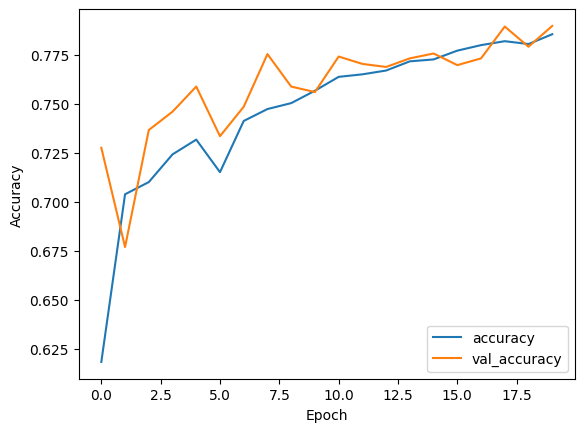

In [37]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('report/src/images/lstm_accuracy.png')
plt.show()

In [38]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Loss: 0.6063, Accuracy: 0.7938


250/250 [==============================] - 47s 182ms/step


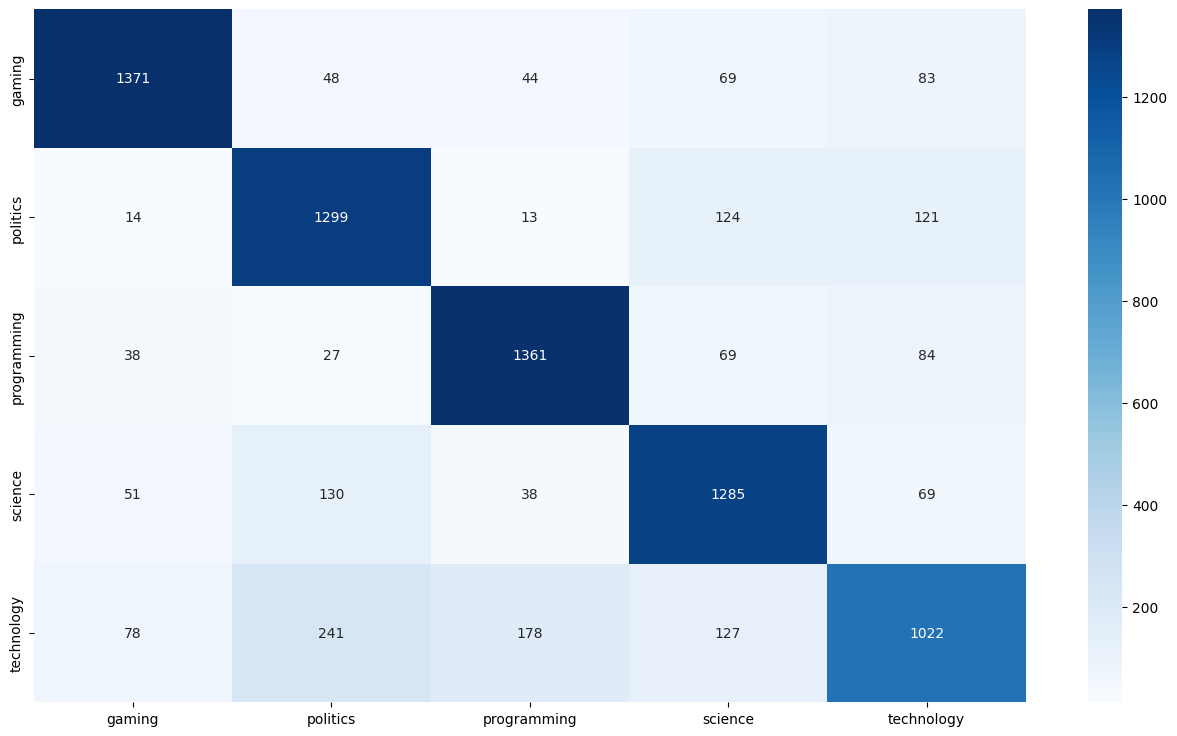

In [39]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(16, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.savefig('report/src/images/lstm_confusion_matrix.png')
plt.show()

250/250 [==============================] - 45s 180ms/step


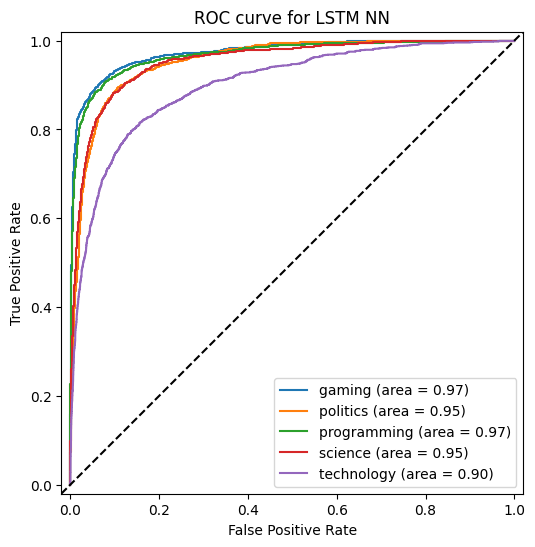

In [40]:
# plot roc curve 

from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

labels = label_encoder.classes_


y_score = model.predict(X_test)

# Plot ROC curve
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
limits = [-0.02, 1.02]
plt.figure(figsize=(6, 6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')
plt.plot(limits, limits,'k--')
plt.xlim(limits)
plt.ylim(limits)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(f'ROC curve for LSTM NN')
plt.gca().set_aspect('equal')
plt.savefig(f'report/src/images/roc_lstm.png', bbox_inches='tight')
plt.show()